This notebook investigates a mechanism by which a fit can start off "smarter" i.e. with parameters in the right ballpark, as ROOT can sometimes be picky

In [1]:
import numpy as np
import scipy
import pandas as pd
from scipy.stats import chisquare
import matplotlib.pyplot as plt

In [2]:
import ROOT

Welcome to ROOTaaS 6.06/04


In [3]:
ROOT.gStyle.SetOptFit(1111)
ROOT.TH1.SetDefaultSumw2(True)


In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 10)

In [6]:
import common_utils as cu
import runCalibration as rc

In [7]:
pairs_file = cu.open_root_file("pairs_QCDFlatFall15PU0to50NzshcalRaw_MP_ak4_ref10to5000_l10to5000_dr0p4_fall15JEC.root")

In [8]:
pairs_tree = cu.get_from_file(pairs_file, "valid")

In [9]:
c = ROOT.TCanvas("canv", "", 600, 400)

In [142]:
h = ROOT.TH1D("hrsp", ";response;", 100, 0, 5)

TFile::Append:0: RuntimeWarning: Replacing existing TH1: hrsp (Potential memory leak).


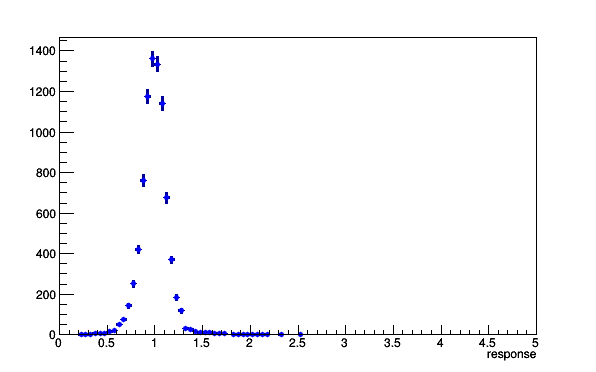

In [143]:
pairs_tree.Draw("rsp>>hrsp", "0<TMath::Abs(eta) && TMath::Abs(eta)<0.348 && ptRef<240 && ptRef>200 && numPUVertices>15 && numPUVertices<25")
c.Draw()

In [55]:
burr3_fit = ROOT.TF1("burr3", "[2]*[0]*[1]*pow((x-[3])/[4], -1.-[0]) / pow(1+pow((x-[3])/[4], -[0]), 1+[1] )", 0, 5)

In [56]:
def setup_burr3(p0=3.64850, p1=7.06077e-01, p2=1.28317e+04, p3=-1.50503e-02, p4=4.87032e-01):
    print "using", p0, p1, p2, p3, p4
    burr3_fit.SetParameter(0, p0)  # shape
    burr3_fit.SetParameter(1, p1)  # shape
    burr3_fit.SetParameter(2, p2)  # Normalisation
    burr3_fit.SetParameter(3, p3)  # location
    burr3_fit.SetParameter(4, p4)  # scale

In [57]:
setup_burr3()

using 3.6485 0.706077 12831.7 -0.0150503 0.487032


In [15]:
with pd.HDFStore('out_burr_quantiles.h5') as store:
    print store
    df_qvals = store['xValues']
    df = store['results']

<class 'pandas.io.pytables.HDFStore'>
File path: out_burr_quantiles.h5
/results            frame        (shape->[86792,10])
/xValues            frame        (shape->[1,5])     


In [16]:
df = df[(df!=0).all(axis=1)]

In [17]:
import sys
print sys.getsizeof(df) / (1024.*1024), "MB"

7.2839050293 MB


In [18]:
df.sample(n=10)

,p0,p1,p2,p3,p4,q0,q1,q2,q3,q4
35098,3.5,7.0,1.0,-4.0,9.5,3.4083542151,4.1746269876,4.5631476325,4.8120232738,4.9657337411
35548,3.5,8.0,1.0,-2.5,4.5,2.4878084572,3.3970208632,4.0211679794,4.5280115493,4.9065180859
63896,6.5,7.0,1.0,-5.0,2.5,0.0408684497,0.2320826627,0.5716445802,1.1873477470,2.7380984830
30594,3.0,7.0,1.0,-2.0,1.5,0.1448671270,0.6127502211,1.2194014241,2.1355572629,3.8835436863
15582,1.5,10.0,1.0,-2.5,2.5,1.0436727660,2.3730902739,3.3788595343,4.2178355014,4.8456782474
83747,9.0,2.0,1.0,-3.5,5.5,1.2780262976,1.9767476913,2.5220866271,3.1643425053,4.2367426857
36998,4.0,1.0,1.0,-0.5,8.0,1.9796041458,3.2415972465,4.0042043038,4.5492962610,4.9148707487
20330,2.0,6.5,1.0,-2.0,4.5,2.0408171010,3.1990193583,3.9484928417,4.5141247517,4.9070660864
92286,10.0,2.0,1.0,-3.5,2.5,0.0189220688,0.1068289471,0.2608541679,0.5357332080,1.2440519142
63440,6.5,5.5,1.0,-2.0,1.0,0.0164155804,0.0933784395,0.2311254565,0.4853397311,1.1846807620


In [19]:
df.shape

(86792, 10)

In [20]:
df_qvals

,q0,q1,q2,q3,q4
0,0.05,0.25,0.5,0.75,0.95


In [21]:
quantiles = df_qvals.iloc[0].values

In [86]:
# get quantiles from histogram
def get_hist_quanties(hist, quantiles):
    qvals = np.ndarray(len(quantiles), 'd')
    hist.GetQuantiles(len(quantiles), qvals, quantiles)
    return qvals

In [144]:
hist_quantiles = get_hist_quanties(h, df_qvals.iloc[0].values)

In [145]:
df2 = df.copy()

In [146]:
for i, qx in enumerate(df_qvals.columns):
#     print qx, i
    df2[qx] = (df2[qx] - hist_quantiles[i])**2
df2['var'] = df2[df_qvals.columns.values].sum(axis=1)

In [147]:
df2 = df2.sort_values('var')

In [148]:
param_cols = [p for p in df.columns.values if p.startswith('p')]

In [149]:
df_chosen = df2[param_cols].head(10)

In [150]:
df_chosen


,p0,p1,p2,p3,p4
65666,7.0,1.0,1.0,3.5,2.5
83434,9.0,1.0,1.0,4.0,3.0
83413,9.0,1.0,1.0,3.5,2.5
47129,5.0,1.0,1.0,4.5,3.5
47151,5.0,1.0,1.0,5.0,4.0
47108,5.0,1.0,1.0,4.0,3.0
27330,3.0,1.0,1.0,4.0,3.0
27351,3.0,1.0,1.0,4.5,3.5
65730,7.0,1.0,1.0,5.0,4.0
27309,3.0,1.0,1.0,3.5,2.5


 [  7.00000000e+00   1.00000000e+00   1.05574299e-18   3.50000000e+00
   2.50000000e+00]
using 7.0 1.0 1.05574298855e-18 3.5 2.5
[  9.00000000e+00   1.00000000e+00   4.95732259e-19   4.00000000e+00
   3.00000000e+00]
using 9.0 1.0 4.95732259067e-19 4.0 3.0
[  9.00000000e+00   1.00000000e+00   6.61063781e-19   3.50000000e+00
   2.50000000e+00]
using 9.0 1.0 6.61063781475e-19 3.5 2.5
[  5.00000000e+00   1.00000000e+00   1.69346263e-18   4.50000000e+00
   3.50000000e+00]
using 5.0 1.0 1.69346263115e-18 4.5 3.5
[  5.00000000e+00   1.00000000e+00   2.10753448e-19   5.00000000e+00
   4.00000000e+00]
using 5.0 1.0 2.10753448058e-19 5.0 4.0
[  5.00000000e+00   1.00000000e+00   1.45457721e-19   4.00000000e+00
   3.00000000e+00]
using 5.0 1.0 1.45457720917e-19 4.0 3.0
[ 3.  1.  1.  4.  3.]
using 3.0 1.0 1.0 4.0 3.0
[ 3.   1.   1.   4.5  3.5]
using 3.0 1.0 1.0 4.5 3.5
[ 7.  1.  1.  5.  4.]
using 7.0 1.0 1.0 5.0 4.0
[ 3.   1.   1.   3.5  2.5]
using 3.0 1.0 1.0 3.5 2.5


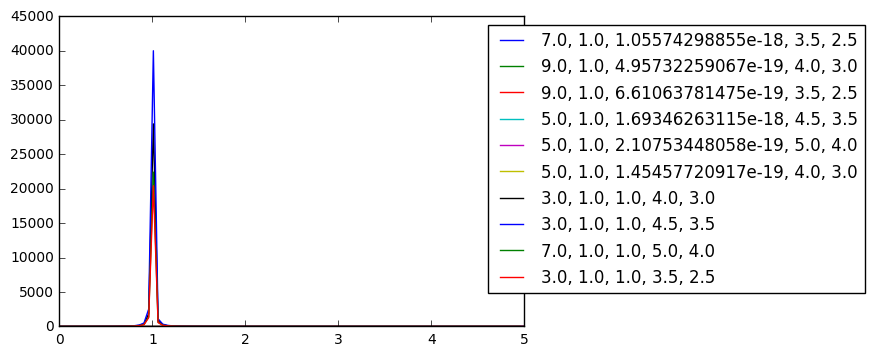

In [154]:
for row in df_chosen.iterrows():
    print row[1].values
    xvals = np.linspace(0, 5, 100)
    setup_burr3(*row[1].values)
    yvals = [burr3_fit.Eval(x) for x in xvals]
    plt.plot(xvals, yvals, label=', '.join([str(v) for v in row[1].values]))
plt.legend(loc='upper right', bbox_to_anchor=(1.75,1))

In [156]:
def fit_hist(hist, fit_range=None):
    """Fit to histogram.
    Returns mode, error, and other info.

    Parameters
    ----------
    hist : 1D histogram to be fitted
    fit_range : list/tuple, optional
        (Lower, upper) limits of fit range. If None, then no fit range enforced.

    Returns
    -------
    fit_status : int
        Fit status result
    fit_mode : float
        Mode of fitted function
    fit_mode_err : float
        Error of mode of fitted function
    fit_ptr : TFitResultPtr
        TFitResultPtr from hist fitting

    Raises
    ------
    RuntimeError
        If `fitter` not in list of acceptable fit distribution options
    """

    fit_options = "ES"

    # Do preliminary fit
    for rough_counter, row in enumerate(df_chosen.iterrows()):
        if rough_counter > 9:
            break

        fit_ptr = None
        fit_status, fit_mode, fit_mode_err = -999, -999, -999
        
        params = row[1].values
        setup_burr3(*params)
        func_max = burr3_fit.GetMaximum()
        hist_max = hist.GetMaximum()
        params[2] = hist_max / func_max
        setup_burr3(*params)
#         break
        
        # Try the fit mutliple times, because it can converge on the 2nd or 3rd
        # iteration but not on the 1st...
        fit_counter_start = 4
        fit_counter = fit_counter_start
        while ((fit_status != 0 and fit_counter > 0) or 
               (fit_counter > 0 and fit_counter < fit_counter_start and hist.GetFunction("burr3").GetMaximumX() < 0.001)):
            print 'Iterations left:', fit_counter
            if fit_range:
                fit_ptr = hist.Fit("burr3", fit_options + "R", "",
                                   fit_range[0], fit_range[1])
            else:
                fit_ptr = hist.Fit("burr3", fit_options)
            fit_status = fit_ptr.Status()
            print 'Fit status:', fit_status
            fit_counter -= 1
            if fit_status == 0 and hist.GetFunction("burr3").GetMaximumX() > 0.001:
                burr_fn = hist.GetFunction("burr3")
                fit_mode = burr_fn.GetMaximumX()
                cov = fit_ptr.GetCovarianceMatrix()
                c = burr_fn.GetParameter(0)
                d = burr_fn.GetParameter(1)
                mu = burr_fn.GetParameter(3)
                s = burr_fn.GetParameter(4)
                fit_mode_err = rc.calc_burr_mode_error(mode=fit_mode, c=c, d=d, s=s, mu=mu, cov=cov)
#                 print fit_status, fit_mode, fit_err
        
                return fit_status, fit_mode, fit_mode_err, fit_ptr
                



In [157]:
results = fit_hist(h, [0, 2])
print 'Mode:', results[1], '±', results[2]
h.Draw()
c.Draw()

using 7.0 1.0 1.0 3.5 2.5
using 7.0 1.0 1.05574298855e-18 3.5 2.5
Iterations left: 4
Fit status: 4
Iterations left: 3
Fit status: 4
Iterations left: 2
Fit status: 4
Iterations left: 1
Fit status: 4
using 9.0 1.0 1.0 4.0 3.0
using 9.0 1.0 4.95732259067e-19 4.0 3.0
Iterations left: 4
Fit status: 4
Iterations left: 3
Fit status: 4
Iterations left: 2
Fit status: 4
Iterations left: 1
Fit status: 4
using 9.0 1.0 1.0 3.5 2.5
using 9.0 1.0 6.61063781475e-19 3.5 2.5
Iterations left: 4
Fit status: 4
Iterations left: 3
Fit status: 4
Iterations left: 2
Fit status: 4
Iterations left: 1
Fit status: 4
using 5.0 1.0 1.0 4.5 3.5
using 5.0 1.0 1.69346263115e-18 4.5 3.5
Iterations left: 4
Fit status: 4
Iterations left: 3
Fit status: 4
Iterations left: 2
Fit status: 4
Iterations left: 1
Fit status: 4
using 5.0 1.0 1.0 5.0 4.0
using 5.0 1.0 2.10753448058e-19 5.0 4.0
Iterations left: 4
Fit status: 4
Iterations left: 3
Fit status: 4
Iterations left: 2
Fit status: 4
Iterations left: 1
Fit status: 4
using 5.0 

Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: Abnormal termination of minimization.
Fit:0: RuntimeWarning: A

TypeError: 'NoneType' object has no attribute '__getitem__'

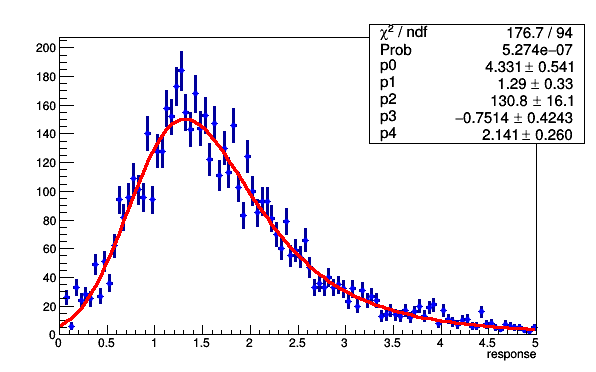

In [103]:
h.Draw()
burr3_fit.Draw("SAME")
c.Draw()